In [37]:
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

pi = np.pi

import constants

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']

import solvers
import particles
import fields
import analytic_models
import utilities

from rsbeams.rsptcls import bunch




0.08937980875482192


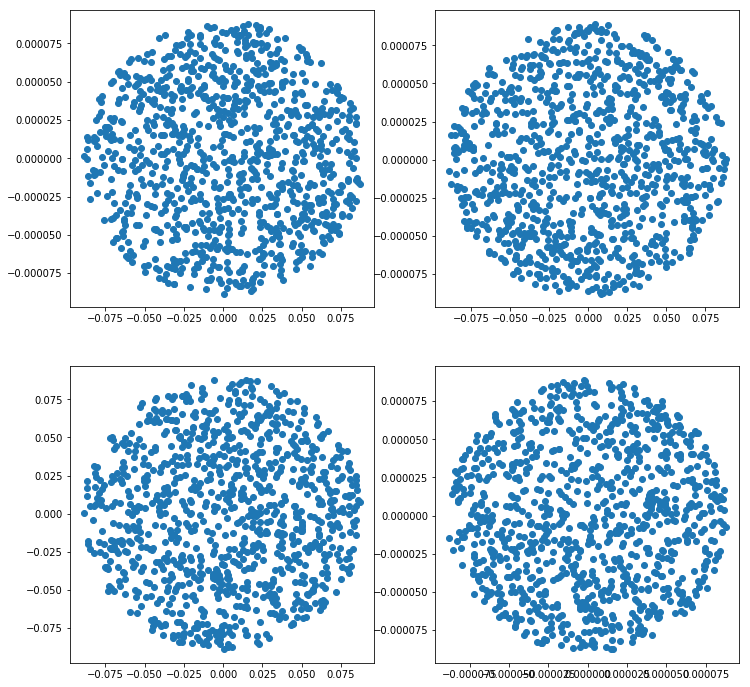

In [95]:
## Particle definitions 
sigma_x = 0.1
Q_mks = 1.0e-10
Q = constants.charge_mks_to_cgs(Q_mks)

## This is where we initialize a KV distribuiton
npart = 1000
newKVBunch = bunch.StandardBunch(npart, dist='KV')
newKVBunch.set_longitudinal_coordinates(dpop=0.01) #here we reset the dpop value
newKVBunch.set_transverse_coordinates(betax = 1000, betay = 1000)

new_distribution = newKVBunch
new_distribution.type = 'KV'
new_distribution.e_x = 1.0e-10
new_distribution.e_y = 1.0e-10
new_distribution.N = newKVBunch.npart
new_distribution.x = newKVBunch.particles[:,0]
new_distribution.xp = newKVBunch.particles[:,1]
new_distribution.y = newKVBunch.particles[:,2]
new_distribution.yp = newKVBunch.particles[:,3]
new_distribution.z = newKVBunch.particles[:,4]
new_distribution.pz = newKVBunch.particles[:,5]

sigma_x = np.max(np.sqrt(new_distribution.x**2 + new_distribution.y**2))
print sigma_x
## This is where we set the domain size 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 40 ## minimum wavelength to resolve

## This is where we set the energy
E = 0.20e6

## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution, # dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_e, K_e = E)
## Define the fields 
my_kv_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
	L_x_min = L_min, L_y_min = L_min)

r_beam = np.sqrt((my_kv_beam.x)** 2 + (my_kv_beam.y) **2)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_kv_fields.register_solver(field_solver)


# instantiate the kinetics solver
#kinetics_solver = solvers.kinetics_solver_SC2D(ds = 0.01)

maps = solvers.symplectic_maps()
ds = 0.1
def step(fields, particles, ds = ds):

    maps.drift(particles, ds = ds / 2.)
    maps.space_charge_kick_2D(fields, particles, ds = ds)
    maps.drift(particles, ds = ds / 2.)



utilities.plot_beam(my_kv_beam)

In [89]:

x_sim = [np.max(np.abs(my_kv_beam.x))]
y_sim = [np.max(np.abs(my_kv_beam.y))]
k = 0

E0 = np.sum(my_kv_beam.px) + np.sum(my_kv_beam.py)
beam_data = []

H = []
E = [E0]
while k < 100:
    
    step(my_kv_fields, my_kv_beam)
    
    x0 = np.mean(my_kv_beam.x)
    y0 = np.mean(my_kv_beam.y)
    
    x_max = np.max(np.abs(my_kv_beam.x))
    y_max = np.max(np.abs(my_kv_beam.y))
    
    x_sim.append(x_max)
    y_sim.append(y_max)
    
    E0 = np.sum(my_kv_beam.px) + np.sum(my_kv_beam.py)
    
    H.append(utilities.compute_system_energy(my_kv_beam, my_kv_fields))
    
    step_data = [my_kv_beam.x, my_kv_beam.px, my_kv_beam.y, my_kv_beam.py]
    beam_data.append(step_data)
    E.append(E0)
    
    if k%10 == 0:
        print k
        
    k = k + 1


0
10
20
30
40
50
60
70
80
90


In [90]:
k = len(x_sim)
x_a = np.linspace(0, ds * k, k) / 100.
x = np.linspace(0, ds * k, k)
#x = np.linspace(0,5,1000)

r_analyitic = utilities.round_beam_expansion(x_a, 
            my_kv_beam.e_x / np.pi, my_kv_beam.e_y / np.pi, sigma_x / 100., sigma_x / 100., 
            Q_mks , my_kv_beam.gamma, my_kv_beam.m_0)

print sigma_x


0.028267760876788832


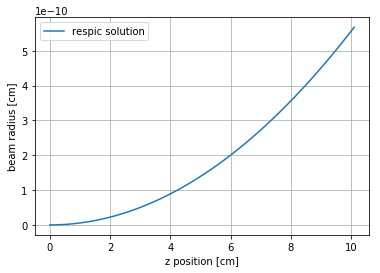

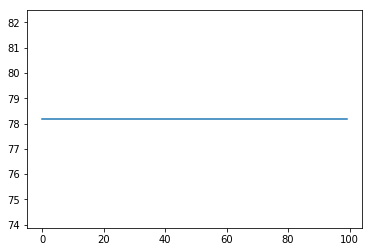

In [91]:


plt.figure()
plt.plot(x, x_sim - x_sim[0] , linewidth = 1.5, label = 'respic solution')
#plt.plot(x_a * 100, r_analyitic[:,0] * 100 - sigma_x, linewidth = 1.5, label = 'analytic solution')
plt.xlabel('z position [cm]')
plt.ylabel('beam radius [cm]')
plt.legend(loc = 0)
plt.grid()



plt.figure()
plt.plot(H)
plt.show()



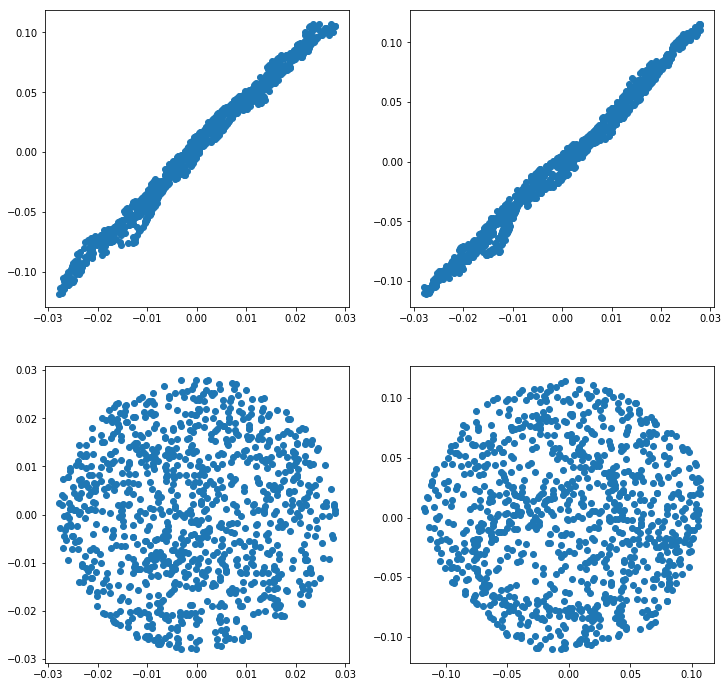

In [92]:

utilities.plot_beam(my_kv_beam)

In [7]:
def generate_kv(n, x_a, x_b, y_a, y_b):
    
    lower = np.asarray([-x_a, -x_b, -y_a, -y_b]) * 2
    upper = np.asarray([x_a, x_b, y_a, y_b]) * 2
    r_sq = np.sum(upper **2. )
    
    k = 0
    coordinates = []
    while k <= n:
        coord = np.random.uniform(lower, upper, 4)
        
        coordinates.append(coord)
        k = k + 1

    real_coordinates = []
    for i in range(0,len(coordinates)):
        coord = coordinates[i]
        x = coord[0]
        xp = coord[1]
        y = coord[2]
        yp = coord[3]
        
        r1 = x**2 / x_a**2 + y**2 /y_a**2
        r2 = xp**2 / x_b**2 + x**2 / x_a**2
        r3 = y**2 / y_a**2 + yp**2 / y_b**2
        
        if (r1 <= 1) and (r2 <= 1) and (r3 <=1 ):
            real_coordinates.append(coord)
           
    
    return np.asarray(real_coordinates)

        
points = generate_kv(1000000, x_a, x_b, y_a, y_b)


def kv(r_0, pr_0, N):
    
    R = np.random.uniform(0, r_0 ** 2, N)
    P = np.random.uniform(0, pr_0 ** 2, N)
    
    theta = np.random.uniform(0, np.pi * 2, N)
    phi = np.random.uniform(0, np.pi * 2, N)
    
    x = np.sqrt(R) * np.cos(theta)
    y = np.sqrt(R) * np.sin(theta)
    xp = np.sqrt(P) * np.cos(phi)
    yp = np.sqrt(P) * np.sin(phi)
    
    return x, y, xp, yp
    

NameError: name 'x_b' is not defined

In [ ]:

N = 10000
x_a = 0.5
x_b = 0.1
y_a = 0.3
y_b = 0.8

#x = points[:,0]
#xp = points[:,1]
#y = points[:,2]
#yp = points[:,3]

x, y, xp, yp = kv(0.1, 0.001, 10000)

plt.figure(figsize = (16,16))
plt.subplot(3,3,1)
plt.hexbin(x, xp, gridsize = 40)#, 'o')
plt.title('x-xp')

plt.subplot(3,3,2)
plt.hexbin(y, yp, gridsize = 40)#,'o')
plt.title('y-yp')

plt.subplot(3,3,3)
plt.hexbin(x, y, gridsize = 40)#,'o')
plt.title('x-y')

plt.subplot(3,3,4)
plt.hexbin(xp, yp, gridsize = 40)#, 'o')
plt.title('xp-yp')

plt.subplot(3,3,5)
plt.hexbin(x, yp, gridsize = 40)#,'o')
plt.title('x-yp')

plt.subplot(3,3,6)
plt.hexbin(y, xp, gridsize = 40)#, 'o')
plt.title('y-xp')
plt.show()

In [ ]:

plt.figure()
plt.hist(x,50)
plt.hist(y,50)

plt.figure()
plt.hist(yp,50)
plt.hist(xp,50)

plt.show()

In [18]:
from rsbeams.rsptcls import bunch

npart = 10000
newKVBunch = bunch.StandardBunch(npart, dist='KV')
newKVBunch.set_longitudinal_coordinates(dpop=0.01) #here we reset the dpop value
newKVBunch.set_transverse_coordinates()
newKVBunch.print_Twiss()

Twiss parameters in use:
betax : 1.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 1.0
gammay : 1.0


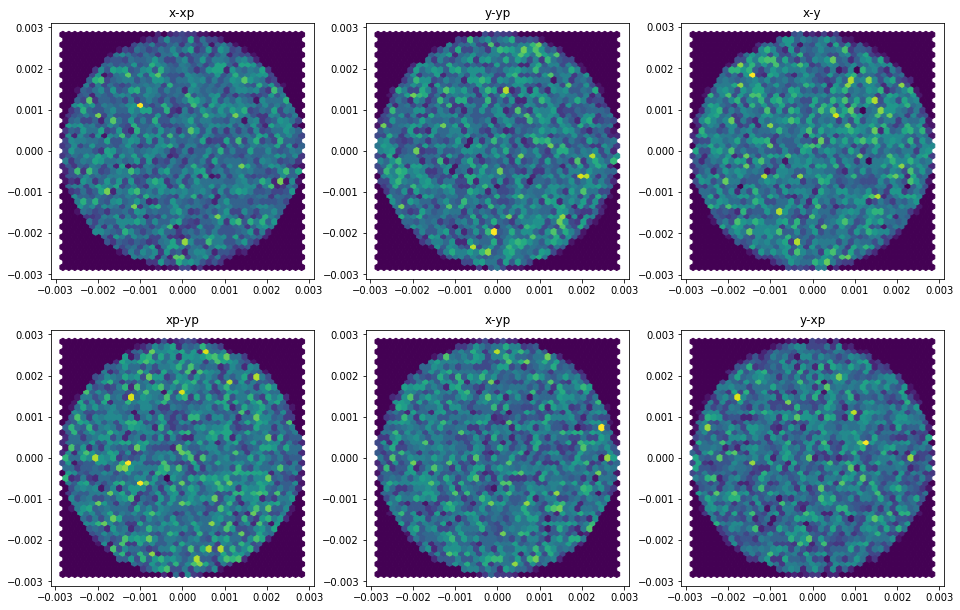

In [19]:
newKVBunch.particles
utilities.plot_rs_beam(newKVBunch.particles)


In [28]:
print newKVBunch.particles



[[-9.63042708e-04 -1.08643978e-03 -1.39540190e-03 ... -4.01901073e-01
  -6.88609211e-03  0.00000000e+00]
 [-1.42195999e-03 -1.42059672e-03  1.80025354e-03 ...  2.78645280e-01
  -1.28663487e-02  1.00000000e+00]
 [ 5.11855972e-04 -2.61374164e-03  4.53136552e-04 ...  4.57818197e-01
   2.79065108e-03  2.00000000e+00]
 ...
 [ 8.41498990e-04  3.26650258e-04 -2.67739080e-03 ... -6.33799024e-01
  -1.60310513e-02  9.99700000e+03]
 [ 3.61846627e-04 -1.73732872e-03  5.33291373e-04 ...  1.34269683e+00
   1.76875584e-02  9.99800000e+03]
 [ 1.25748671e-03 -2.03286183e-03  1.28376706e-03 ... -1.78669203e+00
   7.58913324e-03  9.99900000e+03]]
